# Side-Project: Yellow Cab Pick Up Location Predictor
## Purpose: Given current location, day of the week, time of day, and search radius, help predict the best locations to pick up passengers
#### Best: 
- Locations with highest demand
- Within in the distance of a search radius

# Example: 
### (Note this is for demonstration purposes.  Please make sure to run the rest of the notebook first)

Predicted zip codes for the next pick up (radius = 3 mile(s)):

Rank, Zipcode, Distance, Normalized Fare Score, Normalized Pickup Score
1, 10016, 0.311, 3.21, 44.96
2, 10019, 0.607, 3.12, 62.90
3, 10001, 1.044, 3.16, 42.56
4, 10022, 1.073, 3.17, 58.91
5, 10011, 1.261, 3.07, 43.59


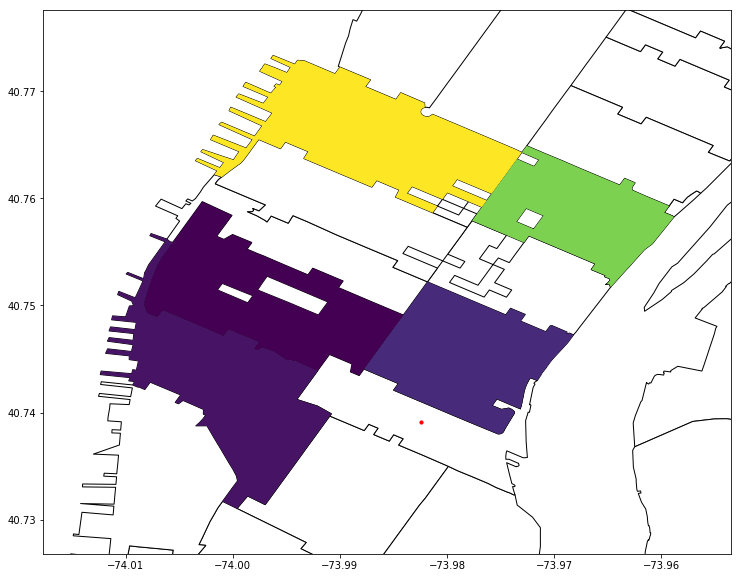

In [1129]:
# predict the top 5 zipcodes to go to next for the best chance of picking up a passenger

day = 2
hour = 17
currentLocation = 10010
#currentLocation = 10002
#currentLocation = 11201
radius = 3
num_results = 5

# generate the heatmap
heatmap_gpd = generateHeatmap(day,hour,zipcodepd['Zipcode'],mean_reg,counts_reg,X_mean_scaler,X_counts_scaler,gdf_locations)

# predict the best pick up zipcodes
sorted_heatmap = predictNextZipcode(heatmap_gpd,currentLocation,radius,num_results)

# Model Generation

## 1. Import Libraries and Constants

In [878]:
# import the modules
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
import datetime as dt
import geopandas as gpd
from geopy.distance import vincenty
from shapely.geometry import Point

In [2]:
#load the zipcode map data and create the geopandas object
#zipcode_fileName = "tl_2015_us_zcta510/tl_2015_us_zcta510.shp"
zipcode_fileName = "nyc_gdf_locs.shp"
print "loading the zipcode file {}".format(zipcode_fileName)
gdf_locations = gpd.read_file(zipcode_fileName)
print "done"

loading the zipcode file nyc_gdf_locs.shp
done


In [3]:
def reverse_zipcode(gdf_ref,coordsMat):
    """do reverse look up of coordinates to find the zipcode
    
    gdf_ref = the geopandas object containing the definition of the zipcodes
    coordsMat = 2D array containing the coordinates (longitude,latitude) 
    """
    
    rows, cols = coordsMat.shape
    zipcode = np.zeros((rows,1))
    
    for i,cur_point in enumerate(coordsMat):
        # convert the coordinates into a shapely point
        cur_point_shp = Point(cur_point)
        
        # use the contains method to produce a list of booleans where the location contains the coordinates
        filter = gdf_ref['geometry'].contains(cur_point_shp)
        
        # get the zipcode
        temp_zipcode = gdf_ref.loc[filter, 'GEOID10'].values
        
        # check if the temp_zipcode is empty where a zipcode is not found
        if (len(temp_zipcode) == 0):
            zipcode[i] = 10
        else:
            zipcode[i] = temp_zipcode[0]
        
    
    return zipcode

##  2. Load and Clean-up/Preprocess the Taxi Trip Data from January to June 2015
Downloaded from https://data.cityofnewyork.us/Transportation/2015-Yellow-Taxi-Trip-Data/ba8s-jw6u

In [216]:
# load the taxi data
taxiFilename = 'yellow_tripdata_2015-01-06.csv'
taxiFilename = 'taxiData_10000k.csv'
raw_data = pd.read_csv(taxiFilename)

In [1106]:
# show the header columns
#print raw_data.columns

# get the shape of the data
rows, cols = raw_data.shape
print "rows {}, cols {}".format(rows,cols)

raw_data[:5]

rows 10000000, cols 19


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
0,7363088,1,2015-01-18 12:47:08,2015-01-18 12:51:17,1,0.70,-73.967995,40.762920,1,N,-73.968224,40.770420,2,5.0,0.0,0.5,0.00,0.0,5.80
1,17620972,2,2015-02-11 02:00:18,2015-02-11 02:01:50,1,0.25,-74.003426,40.743683,1,N,-74.006859,40.744228,2,3.0,0.5,0.5,0.00,0.0,4.30
2,6991441,2,2015-01-17 17:41:58,2015-01-17 17:49:48,1,0.89,-73.976929,40.752228,1,N,-73.970505,40.759041,1,6.5,0.0,0.5,1.62,0.0,8.92
3,40204447,1,2015-04-17 08:01:37,2015-04-17 08:07:21,1,1.80,-73.950722,40.771191,1,N,-73.966606,40.752831,1,7.5,0.0,0.5,1.00,0.0,9.30
4,21542238,2,2015-02-19 19:25:24,2015-02-19 19:47:57,1,3.64,-73.984467,40.743473,1,N,-73.947403,40.779541,1,16.0,1.0,0.5,3.56,0.0,21.36


In [218]:
# shuffle the data
#data = utils.shuffle(data,random_state = 0)

In [583]:
# get a subsample array specified by n_process
n_process = 10000000

data = raw_data[:n_process]
data.shape

(10000000, 19)

### 2.1 Preprocessing Step 1: Remove negative fare datapoints

In [584]:
# preprocessing step 1: remove all points where fare is negative
validfares = data['total_amount'] > 0
data = data[validfares]
data.shape

(9996159, 19)

### 2.2 Preprocessing Step 2: Remove invalid coordinates

In [585]:
# preprocessing step 2: remove data with invalid coordinates such as 0, this will reduce the computational load
coordsMat = data[['pickup_longitude','pickup_latitude']].values

validcoords = (coordsMat[:,0] != 0) & (coordsMat[:,1] != 0)
coordsMat = coordsMat[validcoords]
data = data[validcoords]
print coordsMat
data.shape

[[-73.96799469  40.76292038]
 [-74.0034256   40.74368286]
 [-73.97692871  40.75222778]
 ..., 
 [-73.98911285  40.7568512 ]
 [-73.95454407  40.78086853]
 [-73.95069122  40.77942657]]


(9824274, 19)

### 2.3 Preprocessing Step 3: Convert the coordinates to zip codes and remove invalid zip codes

In [586]:
# preprocess step 3: convert the coordinates to zipcodes, remove invalid zipcodes
zipcode = reverse_zipcode(gdf_locations,coordsMat)

In [587]:
# find out which zipcodes are valid, remove invalid zipcodes with have a value of 10
validzips = zipcode != 10
zipcode = checkVectorDim(zipcode[validzips])
data = data[validzips]
data.shape

(8861033, 19)

### 2.4 Preprocessing Step 4: Convert the pick up time stamp to day of the week and hour of the day

In [588]:
# convert the date timestamp to day of the week and time of day integers
rows2,cols2 = data.shape

dayOfWeek = np.zeros((rows2,1))
timeOfDay = np.zeros((rows2,1))
for i,line in enumerate(data['tpep_pickup_datetime']):
    tempDate = dt.datetime.strptime(line,"%Y-%m-%d %H:%M:%S")
    dayOfWeek[i]=tempDate.weekday()
    timeOfDay[i]=int(tempDate.strftime("%H"))

## 3. Generate the X, Y features and Fit Data to Model

In [1025]:
# Create new DataFrame to aggregate and calculate statistics based on zipcode, dayOfWeek, and timeOfDay
col_names = ['total_amount','Zipcode','dayOfWeek','timeOfDay']
Xpd = pd.DataFrame(np.hstack((checkVectorDim(data['total_amount'].values),zipcode,dayOfWeek,timeOfDay)),columns=col_names)
Xpd.shape

(8861033, 4)

### 3.1 Split the data into Training and Cross-Validation Sets

In [1027]:
# split into training and cross-validation data (CV), assume 20% to 80% split
data_split_index = int(rows2 * 0.2)

# training data
Xpd_train = Xpd[:data_split_index]
print Xpd_train.shape

# cross validation data
Xpd_CV = Xpd[data_split_index:]
print Xpd_CV.shape

(1772206, 4)
(7088827, 4)


In [1052]:
# Aggregate and calculate statistics based on zipcode, dayOfWeek, and timeOfDay

# average fare amount
grouped_mean_train = Xpd_train.groupby(['Zipcode','dayOfWeek','timeOfDay']).aggregate(np.mean)
grouped_mean_train.columns = ['avg_total_amount']
grouped_mean_CV = Xpd_CV.groupby(['Zipcode','dayOfWeek','timeOfDay']).aggregate(np.mean)
grouped_mean_CV.columns = ['avg_total_amount']

# normalized number of rides in each period
grouped_counts_train = Xpd_train.groupby(['Zipcode','dayOfWeek','timeOfDay']).aggregate(np.count_nonzero)
grouped_counts_train.columns = ['normalized pick up counts']
grouped_counts_CV = Xpd_CV.groupby(['Zipcode','dayOfWeek','timeOfDay']).aggregate(np.count_nonzero)
grouped_counts_CV.columns = ['normalized pick up counts']

In [1080]:
# assign the y values which contain the aggregated means
y_mean_train = checkVectorDim(grouped_mean_train.values/np.max(grouped_mean_train.values)*100)
y_mean_CV = checkVectorDim(grouped_mean_CV.values/np.max(grouped_mean_train.values)*100)
y_counts_train = checkVectorDim(grouped_counts_train.values/np.max(grouped_counts_train.values)*100)
y_counts_CV = checkVectorDim(grouped_counts_CV.values/np.max(grouped_counts_CV.values)*100)

In [1081]:
# Write preprocessed data to csv
#Xpd_train.to_csv('taxiData_10000k_train_preprocessed.csv',index=False)
#Xpd_CV.to_csv('taxiData_10000k_CV_preprocessed.csv',index=False)

In [1082]:
# generate the X feature matrice from the multi-indexed dataframe by calling generateX
X_mean_train = generateX(grouped_mean_train)
X_mean_CV = generateX(grouped_mean_CV)

X_counts_train = generateX(grouped_counts_train)
X_counts_CV = generateX(grouped_counts_CV)

In [1083]:
print X_mean_train.shape
print X_mean_CV.shape

(14610, 5518)
(19134, 5518)


### 3.2 Feature normalization and model fitting using ridge linear regression

In [1084]:
# perform feature normalization 

# feature normalize 
X_mean_scaler = preprocessing.StandardScaler()
X_mean_scaler.fit(X_mean_train)
X_mean_train_scaled = X_mean_scaler.transform(X_mean_train)
X_mean_CV_scaled = X_mean_scaler.transform(X_mean_CV)
print "n samples: {}".format(X_mean_scaler.n_samples_seen_)

# feature normalize 
X_counts_scaler = preprocessing.StandardScaler()
X_counts_scaler.fit(X_counts_train)
X_counts_train_scaled = X_mean_scaler.transform(X_counts_train)
X_counts_CV_scaled = X_mean_scaler.transform(X_counts_CV)

print "n samples: {}".format(X_counts_scaler.n_samples_seen_)

n samples: 14610
n samples: 14610


In [1085]:
# machine learing: perform regression
mean_reg = linear_model.Ridge(alpha=10000)
mean_reg.fit(X_mean_train_scaled,y_mean_train)

Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [1086]:
# machine learing: perform regression
counts_reg = linear_model.Ridge(alpha=300)
counts_reg.fit(X_counts_train_scaled,y_counts_train)

Ridge(alpha=300, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [1087]:
# generate the predicted values based on the model
y_mean_train_pred = mean_reg.predict(X_mean_train_scaled)
y_mean_CV_pred = mean_reg.predict(X_mean_CV_scaled)
y_counts_train_pred = counts_reg.predict(X_counts_train_scaled)
y_counts_CV_pred = counts_reg.predict(X_counts_CV_scaled)

In [1088]:
# calculate the r^2 and mean squared error
mean_train_r2 = mean_reg.score(X_mean_train_scaled,y_mean_train)
mean_CV_r2 = mean_reg.score(X_mean_CV_scaled,y_mean_CV)
mean_train_mse = metrics.mean_squared_error(y_mean_train,y_mean_train_pred) 
mean_CV_mse = metrics.mean_squared_error(y_mean_CV,y_mean_CV_pred)
print "Fitting Data: Average Total Amount Fare"
print "  Training Data:\n    r^2: {:.2f}\n    MSE: {:.2f}".format(mean_train_r2,mean_train_mse)
print "  Cross-Validation Data:\n    r^2: {:.2f}\n    MSE: {:.2f}".format(mean_CV_r2,mean_CV_mse)

counts_train_r2 = counts_reg.score(X_counts_train_scaled,y_counts_train)
counts_CV_r2 = counts_reg.score(X_counts_CV_scaled,y_counts_CV)
counts_train_mse = metrics.mean_squared_error(y_counts_train,y_counts_train_pred) 
counts_CV_mse = metrics.mean_squared_error(y_counts_CV,y_counts_CV_pred)

print "\nFitting Data: Total Pickup Counts Fare"
print "  Training Data:\n    r^2: {:.2f}\n    MSE: {:.2f}".format(counts_train_r2,counts_train_mse)
print "  Cross-Validation Data:\n    r^2: {:.2f}\n    MSE: {:f}".format(counts_CV_r2,counts_CV_mse)

Fitting Data: Average Total Amount Fare
  Training Data:
    r^2: 0.59
    MSE: 3.98
  Cross-Validation Data:
    r^2: -0.20
    MSE: 13.84

Fitting Data: Total Pickup Counts Fare
  Training Data:
    r^2: 0.94
    MSE: 14.10
  Cross-Validation Data:
    r^2: 0.92
    MSE: 16.688453


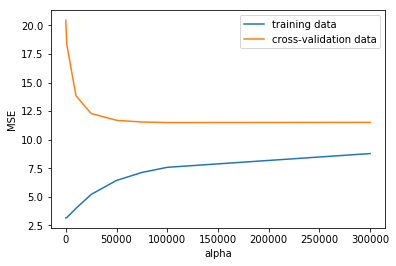

In [1094]:
# alpha selection for X_mean model
plotAlphas([1,10,100,1000,10000,25000,50000,75000,100000,300000],X_mean_train,y_mean_train,X_mean_CV,y_mean_CV)

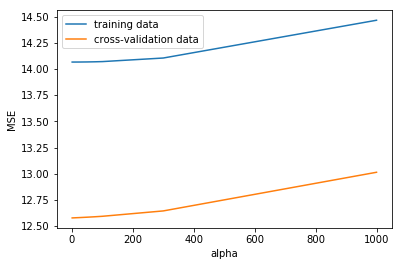

In [1023]:
# alpha selection for X_counts model
plotAlphas([1,10,25,50,75,100,300,1000],X_counts_train,y_counts_train,X_counts_CV,y_counts_CV)

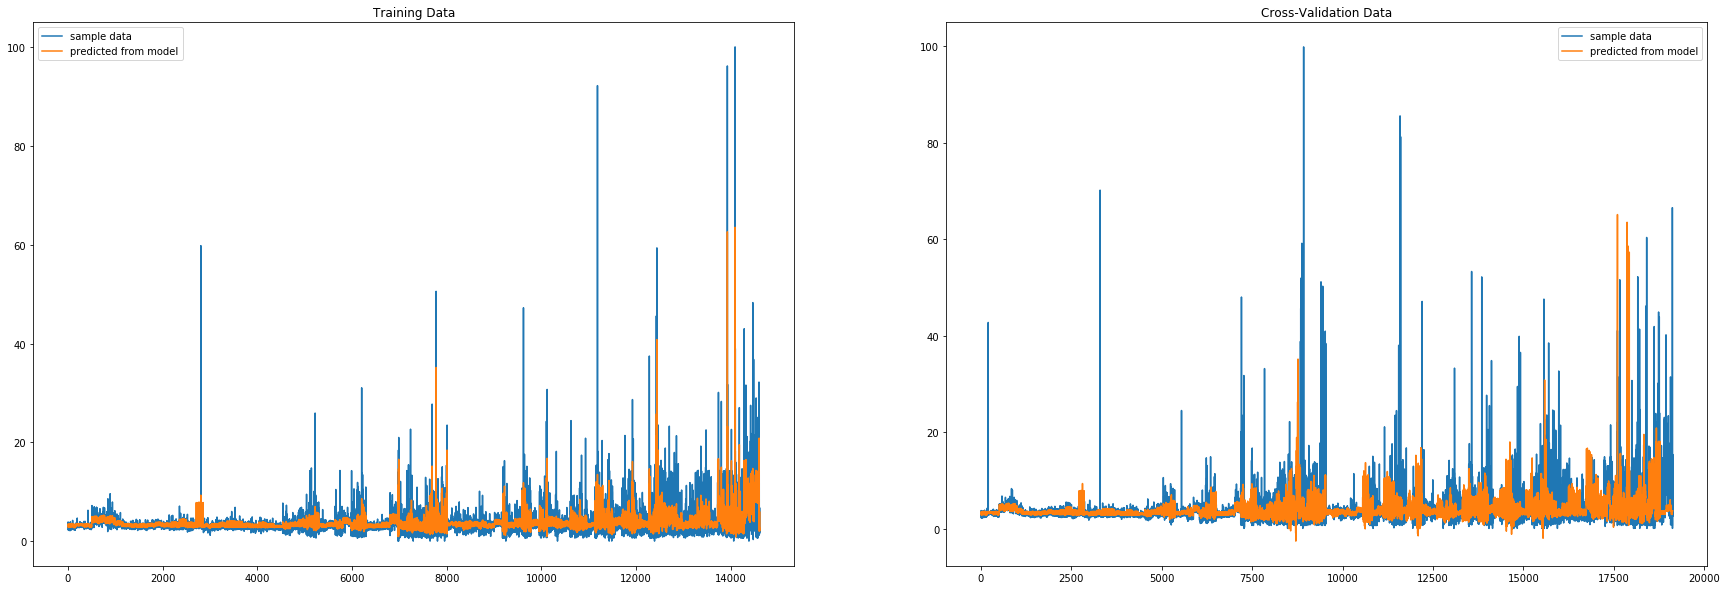

In [1089]:
# Visualize the fitted model
plotFitData(y_mean_train,y_mean_train_pred,y_mean_CV,y_mean_CV_pred)

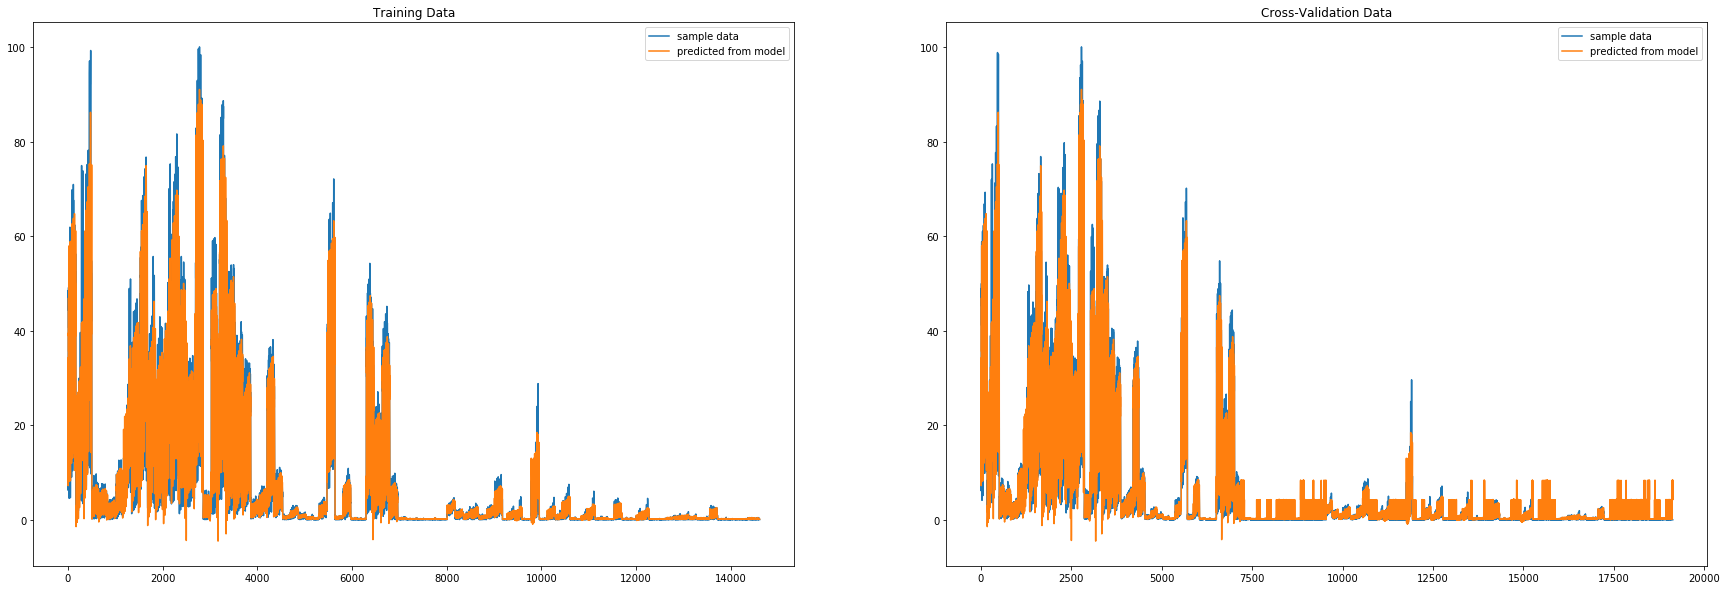

In [1016]:
# Visualize the fitted model
plotFitData(y_counts_train,y_counts_train_pred,y_counts_CV,y_counts_CV_pred)

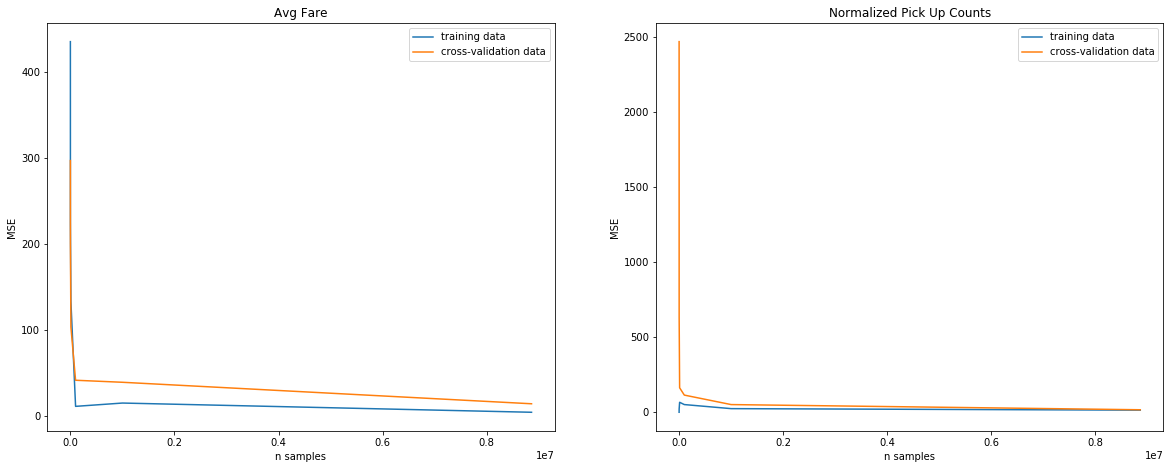

In [1101]:
# generate the learning curve
n_rows,n_cols = Xpd.shape
plotLearningCurve(Xpd,[100,1000,10000,100000,1000000,n_rows],0.2)

## 4. Use the Models to Predict the Best Zip Codes to Find Passengers

Predicted zip codes for the next pick up (radius = 3 mile(s)):

Rank, Zipcode, Distance, Normalized Fare Score, Normalized Pickup Score
1, 11694, 0.000, 3.72, 8.36
2, 11693, 1.958, 3.72, 8.36
3, 11418, 2.438, 2.50, 4.26
4, 11421, 2.453, 3.72, 8.36
5, 11420, 2.616, 3.70, 4.26


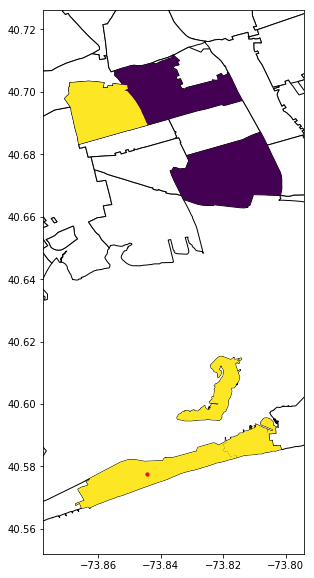

In [1112]:
# predict the top 5 zipcodes to go to next for the best chance of picking up a passenger

day = 2
hour = 17
currentLocation = 11694
#currentLocation = 10002
radius = 3
num_results = 5

# generate the heatmap
heatmap_gpd = generateHeatmap(day,hour,zipcodepd['Zipcode'],mean_reg,counts_reg,X_mean_scaler,X_counts_scaler,gdf_locations)

# predict the best pick up zipcodes
sorted_heatmap = predictNextZipcode(heatmap_gpd,currentLocation,radius,num_results)

## 5. Summary
- Used the Yellow Cab taxi trip data from 2015 to successfully generate a model for predicting best yellow cab pick ups
- Linear regression with a Ridge model was used
  - May be improve accuracy with a different model, more features, more data
  - Poor fit for normalized fare amount, need to find other features
- Data for Yellow cab only.  Incorporate data from Borough Taxis to increase coverage
- Only 10 million of 77 million points used.  Can benefit from distributed computing to help in processing data

## Appendix 1.  Helper Functions

In [1109]:
def generateX(grouped_data):
    """ generate the X matrix to be used to predict y values
    
    grouped_data = this is data that has been grouped used groupby and aggregated
    """
    
    # there is a full listing of zipcodes in index.levels[0], but the labels refer to the index locations in index.levels
    # need to look up the actual zipcodes
    zipindex = grouped_data.index.labels[0]
    newzipindex = np.zeros(zipindex.shape)
    
    for i,cur_zip in enumerate(zipindex):
        newzipindex[i]=grouped_mean.index.levels[0][cur_zip]
    
    # start building the X feature matrix
    X_temp = np.hstack((checkVectorDim(grouped_data.index.labels[1]),checkVectorDim(grouped_data.index.labels[2])))
    
    # generate the categorical zipcode, day, hour interaction features
    rows3, cols3 = X_temp.shape
    
    # read in the csv file containing a listing of sorted nyc zipcodes
    zipcodepd = pd.read_csv('nyc_zipcode_sorted.csv')
    n_zipcodes, n_cols = zipcodepd.shape
    
    # zipFeatures is an array of dimensions (rows3,n_zipcodes) to contain the categorical feature data for the zipcode in 
    # each data entry.  for example, if the zipcode is 10001, the column corresponding to 10001 will be set to 1
    zipFeatures = np.zeros((rows3,n_zipcodes))
    hourZipFeatures = np.zeros((rows3,n_zipcodes*24))
    dayZipFeatures = np.zeros((rows3,n_zipcodes*7))
    
    # loop through the newzipindex and assign 1 to the category column when the right zipcode is found
    for i,cur_zip in enumerate(newzipindex):
        for j,cur_refzip in enumerate(zipcodepd['Zipcode']):
            if cur_zip == cur_refzip:
                zipFeatures[i,j] = 1
                hourZipFeatures[i,X_temp[i,1]*n_zipcodes+j] = 1
                dayZipFeatures[i,X_temp[i,0]*n_zipcodes+j] = 1
                break
    
    # finally build the X feature matrix by combining X_temp and zipFeatures
    X = np.hstack((dayZipFeatures,hourZipFeatures))
    
    return X
    

In [608]:
def generateXDayOrHour(day,hour,zipcodes):
    """ generate the X matrix to be used to predict y values
    
    day = day of the week in number form
    hour = hour of the day
    zipcodes = array of zipcodes, should match the shape of the fitted model
    """
    
    rows4, = zipcodes.shape
    X_features = np.zeros((rows4,rows4*7+rows4*24))
    X_features.shape

    
    # generate the X matrix
    for q,line in enumerate(zipcodes):
        X_features[q,day*rows4+q] = 1
        X_features[q,rows4*7+hour*rows4+q] = 1
    
    return X_features

In [474]:
def plotFitData(y_train,y_train_pred,y_CV=0,y_CV_pred=0):
    """plot the training data and predicted data from the fitted model
    
    y_train = training dataset
    y_train_pred = predicted data from fitted model, must be the same size as y_train
    y_CV = Cross-Validation dataset, can be omitted
    y_CV_pred = predicted data from fitted model, must be the same size as y_CV, can be omitted
    """
    
    
    fig, axes = plt.subplots(1,2,figsize=(30,10))
    plt.sca(axes[0])
    plt.plot(range(y_train.shape[0]),y_train,range(y_train.shape[0]),y_train_pred)
    plt.legend(('sample data','predicted from model'))
    plt.title('Training Data')
    
    if isinstance(y_CV,int) != True:
        plt.sca(axes[1])
        plt.plot(range(y_CV.shape[0]),y_CV,range(y_CV.shape[0]),y_CV_pred)
        plt.legend(('sample data','predicted from model'))
        plt.title('Cross-Validation Data')

    plt.show()

In [1096]:
def predictNextZipcode(heatmap_gpd,currentLocation,radius=10,countLimit=5):
    """predict the best zipcodes to go to pick up passengers
    
    heatmap_gpd = geopandas object containing the shape information for each zipcodee and also the predicted normalized
        pickup counts and avg fare data
    currentLocation = current location
    radius = distance radius limit in miles
    countLimit = number of results to return
    """
    
    # initiate the sorted_heatmap pd DataFrame
    sorted_heatmap = heatmap_gpd[:][['GEOID10','normalized pick up counts','avg fare','geometry']]
    
    # generate centroids
    sorted_heatmap['centroids'] = sorted_heatmap['geometry'].centroid
  
    # check the current coordinate or if zipcode, assign the coordinate from the zipcode centroid
    if isinstance(currentLocation,int) or isinstance(currentLocation,float):
        getZipIndex = heatmap_gpd['GEOID10'].values == "{}".format(int(currentLocation))
        if True in getZipIndex:
            currentCoord = heatmap_gpd[getZipIndex]['geometry'].centroid
            currentCoord = gpd.GeoSeries(currentCoord.values[0])
        else:
            print "Error: zipcode not valid"
    else:
        # assume it is a tuple containing coordinates, convert to a shapely point
        currentCoord = gpd.GeoSeries(Point(currentLocation))
    
    # calculate distance of current location to the centroid of each of the zipcodes
    rows,cols = sorted_heatmap.shape
    distanceVec = np.zeros((rows,1))
    j = 0
    # calls coordToMiles function with calculates the Vincenty distance between the two coordinate points, out in miles
    for i,line in sorted_heatmap.iterrows():
        distanceVec[j] = coordsToMiles(currentCoord.values[0],line['centroids'])
        j = j + 1
    
    
    # add the distances to the sorted list
    sorted_heatmap['distance'] = distanceVec
    
    # check for values within the radius, keep only points within the radius
    sorted_heatmap = sorted_heatmap[sorted_heatmap['distance']<=radius]
    
    # check if any results exists, if not, issue error message and exit the function
    if (len(sorted_heatmap) == 0):
        print "Error: No result found!  Try expanding the search radius"
        return 0
    else:
        # sort the remaining values based on the normalized pick up counts, and keep only number of results specified by countLimit
        sorted_heatmap = sorted_heatmap.sort_values(by='normalized pick up counts',ascending=False)
        sorted_heatmap = sorted_heatmap[:countLimit]
        sorted_heatmap = sorted_heatmap.sort_values(by='distance')
    
    
    # print report to screen
    print "Predicted zip codes for the next pick up (radius = {} mile(s)):\n".format(radius)
    print "Rank, Zipcode, Distance, Normalized Fare Score, Normalized Pickup Score"
    j = 0
    for i,line in sorted_heatmap.iterrows():
        j = j + 1
        print "{}, {}, {:.3f}, {:.2f}, {:.2f}".format(j,line['GEOID10'],line['distance'],line['avg fare'],line['normalized pick up counts'])
    
    # create a figure and get the axes, the set axes to equal 
    fig, ax = plt.subplots(figsize=(30,10))
    
    # plot the zipcode boundaries
    heatmap_gpd.plot(ax=ax,color='white', edgecolor='black')
    
    # plot the sorted zipcodes
    sorted_heatmap.plot(ax=ax,column='normalized pick up counts')
    
    # plot the current location
    currentCoord.plot(ax=ax,color='red',markersize=10)
    
    # adjust the zoom level
    bounding_box = sorted_heatmap['geometry'].bounds
    bounding_box = bounding_box.append(currentCoord.bounds)
    padding_factor = 0.1
    minX = bounding_box['minx'].min()
    maxX = bounding_box['maxx'].max()
    minY = bounding_box['miny'].min()
    maxY = bounding_box['maxy'].max()
    paddingX = (maxX - minX) * padding_factor
    paddingY = (maxY - minY) * padding_factor    
    
    ax.axis([minX - paddingX, maxX + paddingX, minY - paddingY, maxY + paddingY])
    ax.set_aspect('equal')
    plt.show()
    
    return sorted_heatmap

In [886]:
def coordsToMiles(point1,point2):
    """calculates the distance between two coordinate points
    
    point1 = shapely object containg the latitude and longitude of point 1
    point2 = shapely object containg the latitude and longitude of point 2
    """
    
    distance = vincenty((point1.x,point1.y),(point2.x,point2.y)).miles
    
    return distance

In [1017]:
def trainLinearModel(X_train,y_train,alpha_param=0.1):
    """use linear Ridge model to fit training data traindata
    
    X_train = x values for training data
    y_train = y values
    """
    # perform feature normalization
    X_scaler = preprocessing.StandardScaler()
    X_scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    
    # machine learing: perform regression
    reg = linear_model.Ridge(alpha=alpha_param)
    reg.fit(X_train_scaled,y_train)
    
    # generate the predicted values based on the model
    y_train_pred = reg.predict(X_train_scaled)
    
    # calculate the r^2 and mean squared error
    train_r2 = reg.score(X_train_scaled,y_train)
    train_mse = metrics.mean_squared_error(y_train,y_train_pred) 
    
    #print "Fitting Data (alpha = {}):".format(alpha_param)
    #print "  Training Data:\n    r^2: {:.2f}\n    MSE: {:.2f}".format(train_r2,train_mse)
    
    return reg,X_scaler,train_r2,train_mse

In [1020]:
def plotAlphas(alpha_params,X_train,y_train,X_CV,y_CV):
    """generate the learning curve for error vs alphas
    
    alpha_params = array of alpha values to test
    X_train = x values for training data
    y_train = y values for training data
    X_CV = x values for cross-validation data
    y_CV = y values for cross-validation data
    """
    
    num_alphas = len(alpha_params)
    r2Vec = np.zeros((num_alphas,1))
    mseVec = np.zeros((num_alphas,1))
    
    r2Vec_CV = np.zeros((num_alphas,1))
    mseVec_CV = np.zeros((num_alphas,1))
    
    for i,cur_alpha in enumerate(alpha_params):
        tempReg,tempScaler,r2Vec[i],mseVec[i] = trainLinearModel(X_train,y_train,cur_alpha)
        X_CV_scaled = tempScaler.transform(X_CV)
        y_CV_pred = tempReg.predict(X_CV_scaled)
        r2Vec_CV[i] = tempReg.score(X_CV_scaled,y_CV)
        mseVec_CV[i] = metrics.mean_squared_error(y_CV,y_CV_pred)
    
    plt.plot(alpha_params,mseVec,alpha_params,mseVec_CV)
    plt.legend(['training data','cross-validation data'])
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.show()
    
    #return r2Vec,mseVec,r2Vec_CV,mseVec_CV


In [1098]:
def plotLearningCurve(Xpd,n_samplesVec,data_split_index):
    """plot the learning curves of MSE vs number of samples
    
    Xpd = pandas data frame containing total amount of data to be analyzed
    n_samplesVec = array containing the n_samples to be analyzed
    data_split_index = the fraction of data to be training samples (e.g. 0.2, 20% training, 80% cross-validation)
    """
    
    mean_r2Vec = np.zeros((len(n_samplesVec),1))
    mean_r2Vec_CV = np.zeros((len(n_samplesVec),1))
    
    counts_r2Vec = np.zeros((len(n_samplesVec),1))
    counts_r2Vec_CV = np.zeros((len(n_samplesVec),1))
    
    mean_mseVec = np.zeros((len(n_samplesVec),1))
    mean_mseVec_CV = np.zeros((len(n_samplesVec),1))
    
    counts_mseVec = np.zeros((len(n_samplesVec),1))
    counts_mseVec_CV = np.zeros((len(n_samplesVec),1))
    
    for i,cur_n in enumerate(n_samplesVec):
        # split into training and cross-validation data (CV)
        data_split_index = int(cur_n * 0.2)
        
        # training data
        Xpd_train = Xpd[:data_split_index]
        
        # cross validation data
        Xpd_CV = Xpd[data_split_index:cur_n]
        
        # generate the y values
        y_mean_train,grouped_mean_train = generateYmean(Xpd_train)
        y_mean_CV,grouped_mean_CV = generateYmean(Xpd_CV)
        y_counts_train,grouped_counts_train = generateYcounts(Xpd_train)
        y_counts_CV,grouped_counts_CV = generateYcounts(Xpd_CV)
        
        # generate the x values
        X_mean_train = generateX(grouped_mean_train)
        X_mean_CV = generateX(grouped_mean_CV)
        X_counts_train = generateX(grouped_counts_train)
        X_counts_CV = generateX(grouped_counts_CV)
        
        # mean model
        tempReg,tempScaler,mean_r2Vec[i],mean_mseVec[i] = trainLinearModel(X_mean_train,y_mean_train,10000)
        X_mean_CV_scaled = tempScaler.transform(X_mean_CV)
        y_mean_CV_pred = tempReg.predict(X_mean_CV_scaled)
        mean_r2Vec_CV[i] = tempReg.score(X_mean_CV_scaled,y_mean_CV)
        mean_mseVec_CV[i] = metrics.mean_squared_error(y_mean_CV,y_mean_CV_pred)
        
        # counts model
        tempReg,tempScaler,counts_r2Vec[i],counts_mseVec[i] = trainLinearModel(X_counts_train,y_counts_train,300)
        X_counts_CV_scaled = tempScaler.transform(X_counts_CV)
        y_counts_CV_pred = tempReg.predict(X_counts_CV_scaled)
        counts_r2Vec_CV[i] = tempReg.score(X_counts_CV_scaled,y_counts_CV)
        counts_mseVec_CV[i] = metrics.mean_squared_error(y_counts_CV,y_counts_CV_pred)
    
    plt.figure(figsize=(20,7.5))
    plt.subplot(121)
    plt.plot(n_samplesVec,mean_mseVec,n_samplesVec,mean_mseVec_CV)
    plt.legend(['training data','cross-validation data'])
    plt.xlabel('n samples')
    plt.ylabel('MSE')
    plt.title('Avg Fare')
    
    plt.subplot(122)
    plt.plot(n_samplesVec,counts_mseVec,n_samplesVec,counts_mseVec_CV)
    plt.legend(['training data','cross-validation data'])
    plt.xlabel('n samples')
    plt.ylabel('MSE')
    plt.title('Normalized Pick Up Counts')
    plt.show()


In [1099]:
def generateYcounts(Xpd):
    """perform the groupby and aggregation to generate the y values to fit the normalized pick up counts
    
    Xpd = pandas data frame
    """
    
    grouped_counts = Xpd.groupby(['Zipcode','dayOfWeek','timeOfDay']).aggregate(np.count_nonzero)
    grouped_counts.columns = ['normalized pick up counts']
    
    y_counts = checkVectorDim(grouped_counts.values/np.max(grouped_counts.values)*100)
    
    return y_counts,grouped_counts


In [1100]:
def generateYmean(Xpd):
    """perform the groupby and aggregation to generate the y values to fit the avg fare
    
    Xpd = pandas data frame
    """
    
    grouped_mean = Xpd.groupby(['Zipcode','dayOfWeek','timeOfDay']).aggregate(np.mean)
    grouped_mean.columns = ['avg_total_amount']
    
    y_mean = checkVectorDim(grouped_mean.values/np.max(grouped_mean.values)*100)
    
    return y_mean,grouped_mean


In [1103]:
def checkVectorDim(inArray):
	""" Check if the input array is a 1-D Vector, if so enforce n x 1 dimensionality
	
	"""
	
	if (inArray.ndim == 1):
		n = inArray.size
		inArray = inArray.reshape(n,1)
	
	return inArray

In [1114]:
def generateHeatmap(day,hour,zipcodepd,mean_reg,counts_reg,X_mean_scaler,X_counts_scaler,gdf_locations):
    """generate the heatmap of pick up demand
    
    day = day of the week from 0 to 6
    hour = hour of the day from 0 to 23
    zipcodepd = list of zipcodes
    mean_reg = the linearRegression object for the normalized avg fare amount
    counts_reg = the linearRegression object for the normalized pick up counts
    mean_scaler = the preprocessing scaler object for the normalized avg fare amount
    counts_scaler = the preprocessing scaler object for the normalized pick up counts
    gdf_locations = the geopandas dataframe containing the map descriptions for the zipcodes
    """
    
    X_heatmap = generateXDayOrHour(day,hour,zipcodepd)
    X_mean_heatmap = X_mean_scaler.transform(X_heatmap)
    X_counts_heatmap = X_counts_scaler.transform(X_heatmap)
    y_mean_heatmap = mean_reg.predict(X_mean_heatmap)
    y_counts_heatmap = counts_reg.predict(X_mean_heatmap)
    
    heatmap_gpd = gdf_locations
    heatmap_gpd['avg fare'] = y_mean_heatmap[:177]
    heatmap_gpd['normalized pick up counts'] = y_counts_heatmap[:177]
    
    return heatmap_gpd
